In [1]:
## JesseJRuiz_TimeSeries_AnomalyDetection_2019

In [2]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from datetime import timedelta  

%matplotlib inline

from env import path2
from env import file1
from env import file2

# CPS Data


#### Original data: https://data.texas.gov/Social-Services/CPS-1-1-Texas-Child-Population-ages-0-17-by-County/x5xb-idr6

In [4]:
cps = pd.read_csv(path2+file1, sep= ',', header=0)

In [5]:
cps.head()

,Year,County,Region,Child Population,% of Children in Total Population,Total Population
0,2008,Anderson,4-Tyler,11237.0,19.91,56445
1,2008,Andrews,9-Midland,3821.0,27.47,13908
2,2008,Angelina,5-Beaumont,22131.0,26.64,83083
3,2008,Aransas,11-Edinburg,5020.0,19.82,25327
4,2008,Archer,2-Abilene,2216.0,23.96,9248


### Fix the names of the columns

In [6]:
cps = cps.rename(str.lower, axis='columns')

In [7]:
cps.head()

,year,county,region,child population,% of children in total population,total population
0,2008,Anderson,4-Tyler,11237.0,19.91,56445
1,2008,Andrews,9-Midland,3821.0,27.47,13908
2,2008,Angelina,5-Beaumont,22131.0,26.64,83083
3,2008,Aransas,11-Edinburg,5020.0,19.82,25327
4,2008,Archer,2-Abilene,2216.0,23.96,9248


In [8]:
cps = cps.rename(columns={'child population': 'child_pop', '% of children in total population': 'perct_children', 'total population': 'tot_pop'})

In [9]:
cps.head()

,year,county,region,child_pop,perct_children,tot_pop
0,2008,Anderson,4-Tyler,11237.0,19.91,56445
1,2008,Andrews,9-Midland,3821.0,27.47,13908
2,2008,Angelina,5-Beaumont,22131.0,26.64,83083
3,2008,Aransas,11-Edinburg,5020.0,19.82,25327
4,2008,Archer,2-Abilene,2216.0,23.96,9248


### Fix the datatypes of the columns. Change the year to a datetime and add new columns with the year. 

In [10]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 6 columns):
year              2805 non-null int64
county            2805 non-null object
region            2805 non-null object
child_pop         2794 non-null float64
perct_children    2794 non-null float64
tot_pop           2805 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 131.6+ KB


In [11]:
cps.year = pd.to_datetime(cps['year'].astype('str'), format='%Y')

In [12]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 6 columns):
year              2805 non-null datetime64[ns]
county            2805 non-null object
region            2805 non-null object
child_pop         2794 non-null float64
perct_children    2794 non-null float64
tot_pop           2805 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 131.6+ KB


In [13]:
cps.tail()

,year,county,region,child_pop,perct_children,tot_pop
2800,2018-01-01,Yoakum,1-Lubbock,2704.0,29.40,9197
2801,2018-01-01,Young,2-Abilene,4625.0,23.57,19623
2802,2018-01-01,Zapata,11-Edinburg,5659.0,34.42,16440
2803,2018-01-01,Zavala,8-San Antonio,3888.0,30.69,12670
2804,2018-01-01,All Counties,All Regions,NaN,NaN,29366479


In [14]:
cps = cps.rename(columns={'year': 'datetime'})

In [15]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop
0,2008-01-01,Anderson,4-Tyler,11237.0,19.91,56445
1,2008-01-01,Andrews,9-Midland,3821.0,27.47,13908
2,2008-01-01,Angelina,5-Beaumont,22131.0,26.64,83083
3,2008-01-01,Aransas,11-Edinburg,5020.0,19.82,25327
4,2008-01-01,Archer,2-Abilene,2216.0,23.96,9248


In [16]:
cps['year'] = cps['datetime'].dt.year

In [17]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year
0,2008-01-01,Anderson,4-Tyler,11237.0,19.91,56445,2008
1,2008-01-01,Andrews,9-Midland,3821.0,27.47,13908,2008
2,2008-01-01,Angelina,5-Beaumont,22131.0,26.64,83083,2008
3,2008-01-01,Aransas,11-Edinburg,5020.0,19.82,25327,2008
4,2008-01-01,Archer,2-Abilene,2216.0,23.96,9248,2008


### Change the numeric columns to int64 or float64 depending on the data.

In [18]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 7 columns):
datetime          2805 non-null datetime64[ns]
county            2805 non-null object
region            2805 non-null object
child_pop         2794 non-null float64
perct_children    2794 non-null float64
tot_pop           2805 non-null int64
year              2805 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 153.5+ KB


### Checking for nulls

In [19]:
cps.isnull().sum()

datetime           0
county             0
region             0
child_pop         11
perct_children    11
tot_pop            0
year               0
dtype: int64

### Checking for the unique types of values in the region column

In [20]:
cps.region.value_counts()

1-Lubbock        451
7-Austin         330
9-Midland        330
2-Abilene        330
8-San Antonio    308
4-Tyler          253
11-Edinburg      209
3-Arlington      209
5-Beaumont       165
6-Houston        143
10-El Paso        66
All Regions       11
Name: region, dtype: int64

In [21]:
cps.child_pop.value_counts()

278.0       6
354.0       4
251.0       4
2294.0      4
798.0       3
249.0       3
213.0       3
903.0       3
7.0         3
1737.0      3
872.0       3
129.0       3
2951.0      3
4113.0      3
322.0       3
260.0       3
898.0       3
942.0       3
357.0       3
359.0       3
168.0       3
2245.0      2
4507.0      2
2898.0      2
2274.0      2
2703.0      2
6866.0      2
1756.0      2
2153.0      2
9618.0      2
           ..
18358.0     1
398.0       1
6941.0      1
3785.0      1
18385.0     1
326.0       1
5232.0      1
434.0       1
589.0       1
3568.0      1
3880.0      1
483809.0    1
7712.0      1
3384.0      1
55342.0     1
1805.0      1
12614.0     1
1371.0      1
12116.0     1
8068.0      1
10793.0     1
8463.0      1
812.0       1
97607.0     1
227.0       1
217.0       1
7561.0      1
11542.0     1
43939.0     1
502.0       1
Name: child_pop, Length: 2502, dtype: int64

### Now that the datatypes are fixed, change the region into two separate columns that contain region id (numeric) and region name.

In [22]:
cps['region_id'] = cps.region.str.split(pat='-', n=1, expand=True)[0]

In [23]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,4-Tyler,11237.0,19.91,56445,2008,4
1,2008-01-01,Andrews,9-Midland,3821.0,27.47,13908,2008,9
2,2008-01-01,Angelina,5-Beaumont,22131.0,26.64,83083,2008,5
3,2008-01-01,Aransas,11-Edinburg,5020.0,19.82,25327,2008,11
4,2008-01-01,Archer,2-Abilene,2216.0,23.96,9248,2008,2


In [24]:
cps.region_id.value_counts()

1              451
9              330
7              330
2              330
8              308
4              253
3              209
11             209
5              165
6              143
10              66
All Regions     11
Name: region_id, dtype: int64

In [25]:
cps.region =  cps.region.str.split(pat='-', n=1, expand=True)[1]

In [26]:
cps.head()

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,Tyler,11237.0,19.91,56445,2008,4
1,2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008,9
2,2008-01-01,Angelina,Beaumont,22131.0,26.64,83083,2008,5
3,2008-01-01,Aransas,Edinburg,5020.0,19.82,25327,2008,11
4,2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008,2


In [27]:
cps.region.value_counts()

Lubbock        451
Midland        330
Austin         330
Abilene        330
San Antonio    308
Tyler          253
Arlington      209
Edinburg       209
Beaumont       165
Houston        143
El Paso         66
Name: region, dtype: int64

### Checking for nulls

In [28]:
cps.isnull().sum()

datetime           0
county             0
region            11
child_pop         11
perct_children    11
tot_pop            0
year               0
region_id          0
dtype: int64

In [29]:
all_index = list(cps[cps['child_pop'].isnull()].index)
all_index

[254, 509, 764, 1019, 1274, 1529, 1784, 2039, 2294, 2549, 2804]

### Take all these rows with "All Counties" and drop them

In [30]:
cps = cps.drop(cps.index[[all_index]])

In [31]:
cps.isnull().sum()

datetime          0
county            0
region            0
child_pop         0
perct_children    0
tot_pop           0
year              0
region_id         0
dtype: int64

### Change the region_id to a numeric datatype

In [32]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2794 entries, 0 to 2803
Data columns (total 8 columns):
datetime          2794 non-null datetime64[ns]
county            2794 non-null object
region            2794 non-null object
child_pop         2794 non-null float64
perct_children    2794 non-null float64
tot_pop           2794 non-null int64
year              2794 non-null int64
region_id         2794 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 196.5+ KB


In [33]:
cps.region_id = cps.region_id.astype('int64')

In [34]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2794 entries, 0 to 2803
Data columns (total 8 columns):
datetime          2794 non-null datetime64[ns]
county            2794 non-null object
region            2794 non-null object
child_pop         2794 non-null float64
perct_children    2794 non-null float64
tot_pop           2794 non-null int64
year              2794 non-null int64
region_id         2794 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 196.5+ KB


In [35]:
cps.head(10)

,datetime,county,region,child_pop,perct_children,tot_pop,year,region_id
0,2008-01-01,Anderson,Tyler,11237.0,19.91,56445,2008,4
1,2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008,9
2,2008-01-01,Angelina,Beaumont,22131.0,26.64,83083,2008,5
3,2008-01-01,Aransas,Edinburg,5020.0,19.82,25327,2008,11
4,2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008,2
5,2008-01-01,Armstrong,Lubbock,502.0,22.89,2193,2008,1
6,2008-01-01,Atascosa,San Antonio,12615.0,28.78,43829,2008,8
7,2008-01-01,Austin,Houston,6705.0,24.59,27270,2008,6
8,2008-01-01,Bailey,Lubbock,1877.0,29.87,6283,2008,1
9,2008-01-01,Bandera,San Antonio,4080.0,20.08,20314,2008,8


In [36]:
cps.set_index('datetime', inplace=True)

In [37]:
cps.resample('Y')

DatetimeIndexResampler [freq=<YearEnd: month=12>, axis=0, closed=right, label=right, convention=start, base=0]

In [38]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year,region_id
datetime,,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445,2008,4
2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008,9
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083,2008,5
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327,2008,11
2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008,2


In [39]:
cps.county.value_counts()

Schleicher       11
Karnes           11
Terry            11
Nolan            11
Webb             11
Comal            11
Brooks           11
Grayson          11
Knox             11
Menard           11
Bell             11
Panola           11
Brown            11
Sutton           11
Floyd            11
Madison          11
Young            11
Franklin         11
Hardin           11
Chambers         11
Caldwell         11
Van Zandt        11
Anderson         11
Newton           11
Aransas          11
Ochiltree        11
Roberts          11
Williamson       11
Bosque           11
Potter           11
                 ..
Haskell          11
Walker           11
Stonewall        11
Live Oak         11
Foard            11
Hopkins          11
Starr            11
Lipscomb         11
Austin           11
Eastland         11
Terrell          11
Lee              11
Cherokee         11
Coryell          11
San Augustine    11
Burleson         11
Blanco           11
Briscoe          11
Dallam           11


In [40]:
len(cps.year.value_counts())

11

In [41]:
cps.region.value_counts()

Lubbock        451
Midland        330
Austin         330
Abilene        330
San Antonio    308
Tyler          253
Arlington      209
Edinburg       209
Beaumont       165
Houston        143
El Paso         66
Name: region, dtype: int64

# There are 11 years of data. There are 254 counties in the df (all in TX). There are 11 regions (cities/metropolitan areas).

In [42]:
cps.year.value_counts()

2017    254
2015    254
2013    254
2011    254
2009    254
2018    254
2016    254
2014    254
2012    254
2010    254
2008    254
Name: year, dtype: int64

In [43]:
cps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2794 entries, 2008-01-01 to 2018-01-01
Data columns (total 7 columns):
county            2794 non-null object
region            2794 non-null object
child_pop         2794 non-null float64
perct_children    2794 non-null float64
tot_pop           2794 non-null int64
year              2794 non-null int64
region_id         2794 non-null int64
dtypes: float64(2), int64(3), object(2)
memory usage: 174.6+ KB


## Edit dataframe a bit more...
### Drop region_id because its redundant

In [44]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year,region_id
datetime,,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445,2008,4
2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008,9
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083,2008,5
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327,2008,11
2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008,2


In [45]:
cps = cps.drop('region_id', axis=1)

In [46]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445,2008
2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083,2008
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327,2008
2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008


In [47]:
cps.iloc[-1,:]

county                 Zavala
region            San Antonio
child_pop                3888
perct_children          30.69
tot_pop                 12670
year                     2018
Name: 2018-01-01 00:00:00, dtype: object

## Visualize the change of children population over time across the regions.

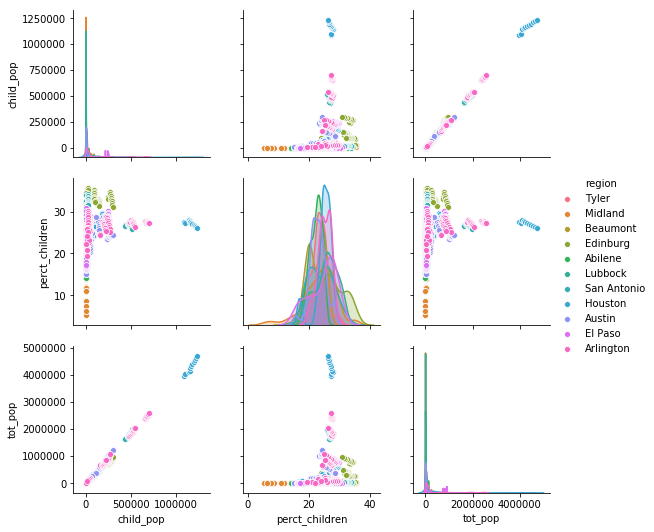

In [48]:
sns.pairplot(cps.drop(columns='year'), hue='region')

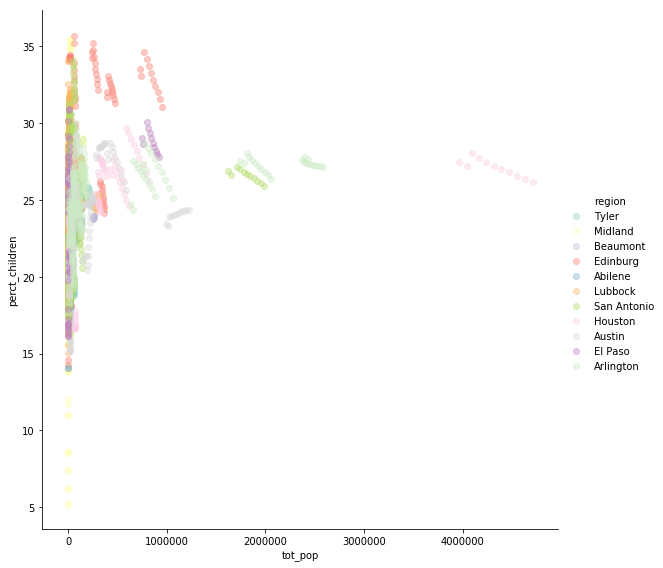

In [49]:
sns.set_palette('Set3')

g = sns.FacetGrid(cps, hue="region", height=8)
g.map(plt.scatter, 'tot_pop', 'perct_children', alpha=0.4)
# plt.figure(figsize=(12,12))
g.add_legend()


In [50]:
cps.tot_pop.describe()

count    2.794000e+03
mean     1.051961e+05
std      3.733768e+05
min      5.700000e+01
25%      6.902250e+03
50%      1.898750e+04
75%      5.150300e+04
max      4.716479e+06
Name: tot_pop, dtype: float64

In [51]:
cps.groupby(['year', 'region'])

In [52]:
cps_by_yr_by_region = cps.groupby(['year', 'region']).agg('sum')

In [53]:
cps_by_yr_by_region

child_pop  perct_children  tot_pop
year region                                         
2008 Abilene       129918.0          662.08   547273
     Arlington    1787328.0          481.94  6623803
     Austin        687621.0          695.22  2815141
     Beaumont      181952.0          343.09   753854
     Edinburg      632538.0          514.22  2021188
     El Paso       223615.0          148.50   774524
     Houston      1582378.0          327.88  5859339
     Lubbock       209519.0         1030.15   815358
     Midland       142955.0          680.55   545368
     San Antonio   656179.0          701.35  2483977
     Tyler         261221.0          536.46  1087149
2009 Abilene       130622.0          658.16   552450
     Arlington    1813205.0          477.40  6770397
     Austin        697302.0          689.33  2877349
     Beaumont      181854.0          339.95   758730
     Edinburg      633106.0          508.21  2044913
     El Paso       222485.0          146.30   781204
     Houston      1600259.0          324.54  5990432
     Lubbock       210805.0         1023.20   825458
     Midland       144760.0          673.85   555206
     San Antonio   661421.0          693.65  2529527
     Tyler         261617.0          531.61  1096636
2010 Abilene       129373.0          694.06   550250
     Arlington    1860693.0          497.29  6733179
     Austin        739441.0          712.85  2948364
     Beaumont      184465.0          346.75   767222
     Edinburg      671080.0          516.19  2105700
     El Paso       247132.0          157.11   825913
     Houston      1692993.0          336.15  6087133
     Lubbock       220971.0         1106.98   839586
...                     ...             ...      ...
2016 Beaumont      190318.0          330.45   808167
     Edinburg      714490.0          494.73  2370249
     El Paso       257264.0          144.22   915995
     Houston      1828051.0          319.92  6946624
     Lubbock       235840.0         1038.63   899512
     Midland       161237.0          698.56   614031
     San Antonio   748085.0          657.04  2923361
     Tyler         280061.0          525.99  1186116
2017 Abilene       132625.0          658.92   571340
     Arlington    2034172.0          464.13  7755244
     Austin        869065.0          676.49  3495220
     Beaumont      191504.0          328.26   815056
     Edinburg      721797.0          490.98  2416831
     El Paso       259499.0          143.56   931965
     Houston      1852325.0          317.53  7103171
     Lubbock       238298.0         1029.88   909914
     Midland       162727.0          692.85   621166
     San Antonio   756473.0          652.93  2978568
     Tyler         281787.0          522.79  1198815
2018 Abilene       133098.0          656.55   574231
     Arlington    2055355.0          458.86  7919315
     Austin        886900.0          672.12  3581472
     Beaumont      192648.0          326.40   822135
     Edinburg      728007.0          489.11  2464582
     El Paso       262034.0          143.18   947668
     Houston      1873145.0          314.65  7262352
     Lubbock       240761.0         1025.05   920560
     Midland       164145.0          689.22   628255
     San Antonio   764193.0          649.18  3034265
     Tyler         283530.0          519.95  1211644

[121 rows x 3 columns]

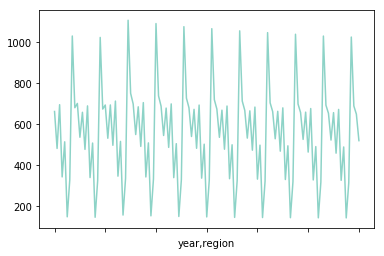

In [54]:
cps_by_yr_by_region.perct_children.plot()

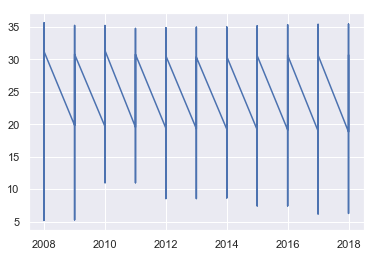

In [55]:
sns.set()
plt.plot(cps.year, cps.perct_children)

# DBSCAN

In [56]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [57]:
cps_dbscan_df = cps[['child_pop', 'tot_pop']]

In [58]:
np_array = cps_dbscan_df.values.astype("float32", copy = False)
np_array[0:10]

array([[11237., 56445.],
       [ 3821., 13908.],
       [22131., 83083.],
       [ 5020., 25327.],
       [ 2216.,  9248.],
       [  502.,  2193.],
       [12615., 43829.],
       [ 6705., 27270.],
       [ 1877.,  6283.],
       [ 4080., 20314.]], dtype=float32)

In [59]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.16463423, -0.13059156],
       [-0.23777765, -0.24453706],
       [-0.05718756, -0.0592353 ],
       [-0.22595201, -0.21394855],
       [-0.25360763, -0.25702   ],
       [-0.2705127 , -0.27591848],
       [-0.15104313, -0.16438653],
       [-0.20933299, -0.20874375],
       [-0.25695118, -0.26496243],
       [-0.23522316, -0.22737706]], dtype=float32)

In [60]:
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

In [61]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
cps_dbscan_df['labels'] = labels
cps_dbscan_df.labels.value_counts()

 0    2750
 1      22
-1      22
Name: labels, dtype: int64

In [63]:
cps_dbscan_df[cps_dbscan_df.labels==-1].head()

,child_pop,tot_pop,labels
datetime,,,
2008-01-01,663309.0,2387963,-1
2008-01-01,1088323.0,3965716,-1
2009-01-01,672235.0,2429276,-1
2009-01-01,1099750.0,4044032,-1
2010-01-01,654263.0,2368139,-1


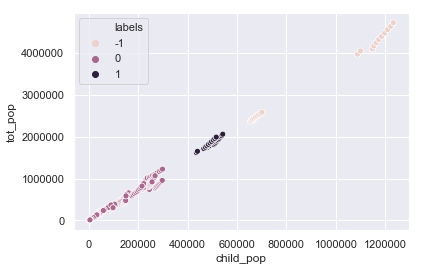

In [64]:
sns.scatterplot(cps_dbscan_df.child_pop, cps_dbscan_df.tot_pop, hue=cps_dbscan_df.labels)
plt.show()

# Select only one Region to explore and to do a DBSCAN

### There are 11 Regions. There are 254 counties.

In [65]:
cps.head()

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Anderson,Tyler,11237.0,19.91,56445,2008
2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008
2008-01-01,Angelina,Beaumont,22131.0,26.64,83083,2008
2008-01-01,Aransas,Edinburg,5020.0,19.82,25327,2008
2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008


In [66]:
regions = list(cps.region.value_counts().index)

In [67]:
regions

['Lubbock',
 'Midland',
 'Austin',
 'Abilene',
 'San Antonio',
 'Tyler',
 'Arlington',
 'Edinburg',
 'Beaumont',
 'Houston',
 'El Paso']

In [68]:
counties = list(cps.county.value_counts().index)

In [69]:
counties

['Schleicher',
 'Karnes',
 'Terry',
 'Nolan',
 'Webb',
 'Comal',
 'Brooks',
 'Grayson',
 'Knox',
 'Menard',
 'Bell',
 'Panola',
 'Brown',
 'Sutton',
 'Floyd',
 'Madison',
 'Young',
 'Franklin',
 'Hardin',
 'Chambers',
 'Caldwell',
 'Van Zandt',
 'Anderson',
 'Newton',
 'Aransas',
 'Ochiltree',
 'Roberts',
 'Williamson',
 'Bosque',
 'Potter',
 'Wise',
 'Uvalde',
 'Maverick',
 'Tom Green',
 'Rains',
 'Cameron',
 'Gonzales',
 'Bandera',
 'Colorado',
 'Callahan',
 'Kenedy',
 'Victoria',
 'Galveston',
 'Shackelford',
 'Stephens',
 'Armstrong',
 'Reagan',
 'Fannin',
 'Wichita',
 'Waller',
 'Jim Hogg',
 'Refugio',
 'Parmer',
 'Denton',
 'Jefferson',
 'Camp',
 'Milam',
 'Montague',
 'Zapata',
 'Collin',
 'Yoakum',
 'Montgomery',
 'Cochran',
 'Duval',
 'Wilbarger',
 'Tarrant',
 'Mills',
 'Sterling',
 'Willacy',
 'Nacogdoches',
 'Liberty',
 'Llano',
 'Crockett',
 'Ector',
 'Hamilton',
 'San Jacinto',
 'Somervell',
 'Polk',
 'Parker',
 'Bastrop',
 'Cass',
 'Bowie',
 'Culberson',
 'Collingsworth',

## First select Lubbock

In [70]:
lubbock = cps[cps['region'] == 'Lubbock']

In [71]:
lubbock

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Armstrong,Lubbock,502.0,22.89,2193,2008
2008-01-01,Bailey,Lubbock,1877.0,29.87,6283,2008
2008-01-01,Briscoe,Lubbock,369.0,23.02,1603,2008
2008-01-01,Carson,Lubbock,1455.0,22.85,6368,2008
2008-01-01,Castro,Lubbock,2252.0,29.73,7576,2008
2008-01-01,Childress,Lubbock,1722.0,22.37,7699,2008
2008-01-01,Cochran,Lubbock,903.0,25.79,3501,2008
2008-01-01,Collingsworth,Lubbock,664.0,21.99,3019,2008
2008-01-01,Crosby,Lubbock,1757.0,27.87,6304,2008


AttributeError: 'FacetGrid' object has no attribute 'set_title'

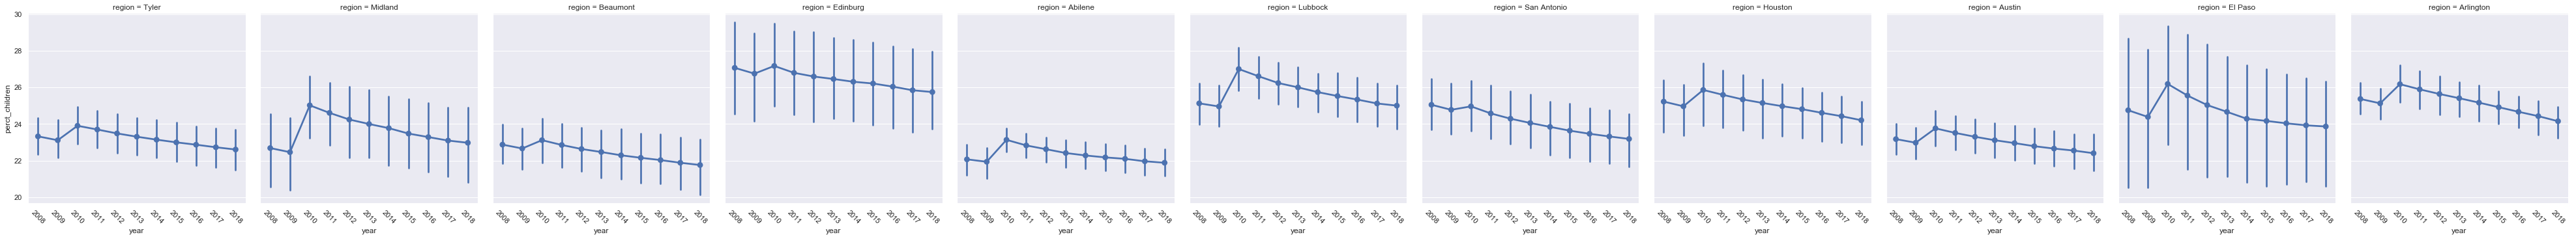

In [73]:
g = sns.factorplot(x='year', y='perct_children', data=cps, col='region')
g.set_xticklabels(rotation=-45)
g.set_title('Percentage of Children in Total Pop')

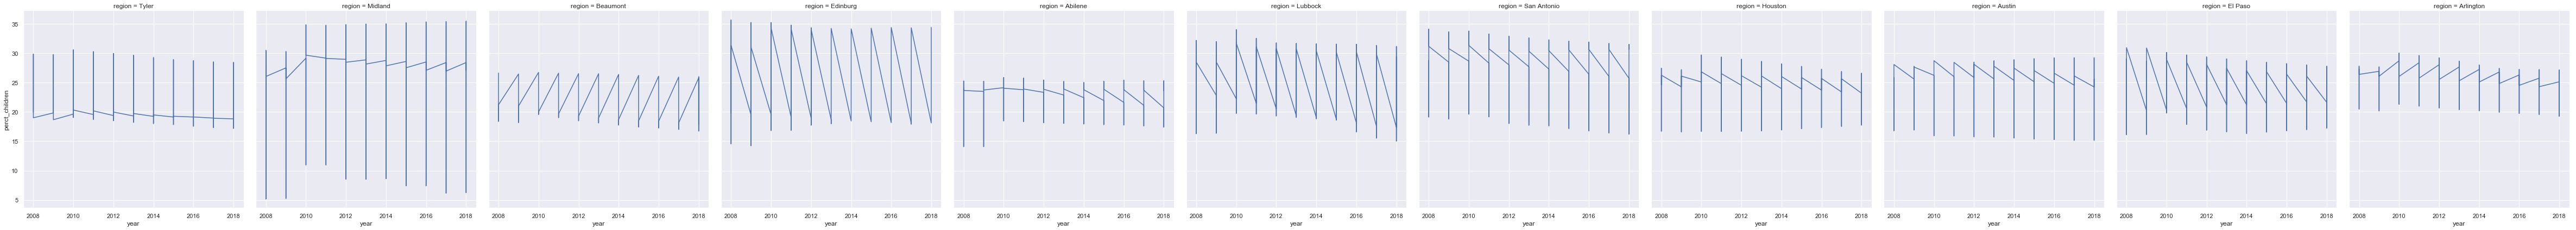

In [74]:
g = sns.FacetGrid(cps, col='region', height=6)
g.map(plt.plot, 'year', 'perct_children')

In [75]:
lubbock.head()

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Armstrong,Lubbock,502.0,22.89,2193,2008
2008-01-01,Bailey,Lubbock,1877.0,29.87,6283,2008
2008-01-01,Briscoe,Lubbock,369.0,23.02,1603,2008
2008-01-01,Carson,Lubbock,1455.0,22.85,6368,2008
2008-01-01,Castro,Lubbock,2252.0,29.73,7576,2008


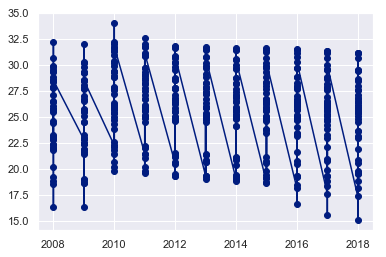

In [76]:
with plt.style.context('seaborn-dark-palette'):
    plt.plot('year', 'perct_children', '-o', data = lubbock)

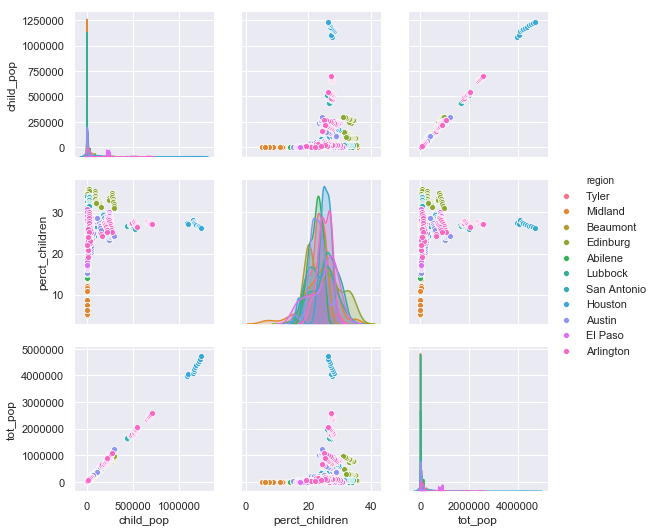

In [77]:
sns.pairplot(cps.drop(columns='year'), hue='region')

In [78]:
cps.groupby('region').sum().sort_values(by='tot_pop')

,child_pop,perct_children,tot_pop,year
region,,,,
Abilene,1440837.0,7362.55,6160729,664290
Midland,1708940.0,7788.51,6501516,664290
Beaumont,2057683.0,3700.97,8664047,332145
El Paso,2729199.0,1625.05,9528164,132858
Lubbock,2496199.0,11588.10,9557439,907863
Tyler,3014261.0,5869.05,12634663,509289
Edinburg,7560363.0,5528.10,24602260,420717
San Antonio,7892247.0,7424.22,30359912,620004
Austin,8696295.0,7595.98,34995199,664290


# Select Abilene, which is the Region with the smallest total population

In [79]:
abilene = cps[cps['region'] == 'Abilene']

In [80]:
abilene

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Archer,Abilene,2216.0,23.96,9248,2008
2008-01-01,Baylor,Abilene,790.0,20.04,3943,2008
2008-01-01,Brown,Abilene,9107.0,23.53,38703,2008
2008-01-01,Callahan,Abilene,3053.0,22.14,13789,2008
2008-01-01,Clay,Abilene,2344.0,21.19,11064,2008
2008-01-01,Coleman,Abilene,1958.0,22.59,8666,2008
2008-01-01,Comanche,Abilene,3295.0,23.24,14180,2008
2008-01-01,Cottle,Abilene,354.0,20.87,1696,2008
2008-01-01,Eastland,Abilene,4003.0,22.00,18195,2008


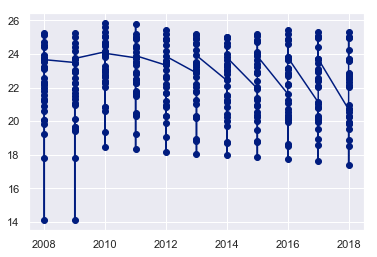

In [81]:
with plt.style.context('seaborn-dark-palette'):
    plt.plot('year', 'perct_children', '-o', data = abilene)

# Select Midland, which is the Region with the 2nd smallest total population

In [82]:
midland = cps[cps['region'] == 'Midland']

In [83]:
midland

,county,region,child_pop,perct_children,tot_pop,year
datetime,,,,,,
2008-01-01,Andrews,Midland,3821.0,27.47,13908,2008
2008-01-01,Borden,Midland,109.0,15.62,698,2008
2008-01-01,Coke,Midland,732.0,19.04,3844,2008
2008-01-01,Concho,Midland,450.0,12.07,3729,2008
2008-01-01,Crane,Midland,1039.0,25.81,4026,2008
2008-01-01,Crockett,Midland,1006.0,23.83,4221,2008
2008-01-01,Dawson,Midland,3400.0,24.41,13926,2008
2008-01-01,Ector,Midland,37761.0,28.86,130849,2008
2008-01-01,Gaines,Midland,4689.0,30.47,15389,2008


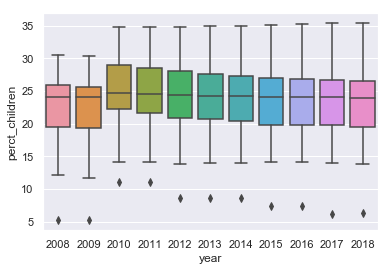

In [84]:
with plt.style.context('seaborn-dark-palette'):
    sns.boxplot(x='year', y='perct_children', data = midland)

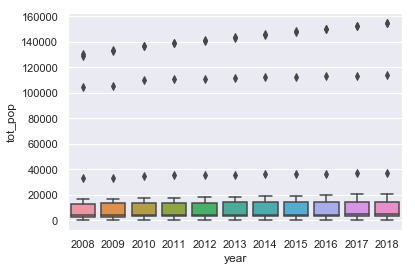

In [85]:
with plt.style.context('seaborn-dark-palette'):
    sns.boxplot(x='year', y='tot_pop', data = midland)

## Further explore the Midland region because the total population and the children population are different than the rest of the regions. 

### Research shows that this area has one of the fastest growing cities, Midland, TX in the USA: https://www.msn.com/en-us/money/realestate/america-fastest-growing-cities/ss-BBULyYT#image=23

In [86]:
mid_by_county_by_yr = midland.groupby(['county','year']).sum()

In [87]:
midland.isnull().sum()

county            0
region            0
child_pop         0
perct_children    0
tot_pop           0
year              0
dtype: int64

In [88]:
mid_by_county_by_yr.head()

child_pop  perct_children  tot_pop
county  year                                    
Andrews 2008     3821.0           27.47    13908
        2009     3893.0           27.50    14156
        2010     4312.0           29.16    14786
        2011     4396.0           29.16    15076
        2012     4443.0           28.96    15343

In [89]:
mid_by_county_by_yr.xs('Andrews', level='county')

,child_pop,perct_children,tot_pop
year,,,
2008,3821.0,27.47,13908
2009,3893.0,27.50,14156
2010,4312.0,29.16,14786
2011,4396.0,29.16,15076
2012,4443.0,28.96,15343
2013,4504.0,28.87,15603
2014,4563.0,28.77,15861
2015,4614.0,28.60,16133
2016,4670.0,28.51,16383


Text(0.5, 1.0, 'Andrews County Percentage of Children in Total Pop')

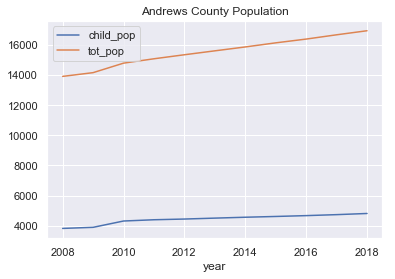

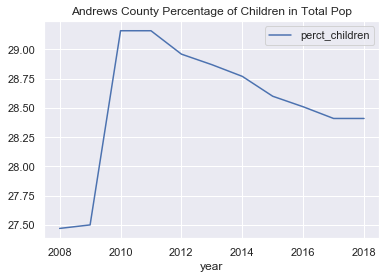

In [90]:
mid_by_county_by_yr.xs('Andrews', level='county')[['child_pop', 'tot_pop']].plot()
plt.title('Andrews County Population')
mid_by_county_by_yr.xs('Andrews', level='county')[['perct_children']].plot()
plt.title('Andrews County Percentage of Children in Total Pop')

Text(0.5, 1.0, 'Andrews Percentage of Children in Total Population')

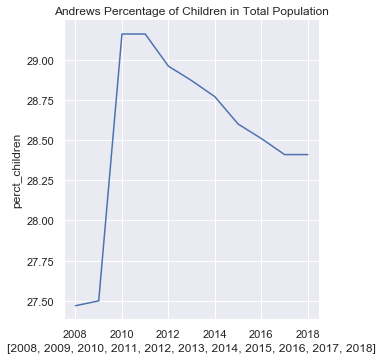

In [91]:
# mid_by_county_by_yr.xs('Andrews', level='county')[['child_pop', 'tot_pop']].plot()
# plt.title('Andrews County Population')
# mid_by_county_by_yr.xs('Andrews', level='county')[['perct_children']].plot()
# plt.title('Andrews County Percentage of Children in Total Pop')
sns.relplot(x=list(mid_by_county_by_yr.xs('Andrews', level='county').index), y='perct_children', data=mid_by_county_by_yr.xs('Andrews', level='county'), kind='line')
plt.title('Andrews Percentage of Children in Total Population')


In [92]:
midland_counties = list(midland.county.value_counts().index.sort_values())

In [93]:
midland_counties

['Andrews',
 'Borden',
 'Coke',
 'Concho',
 'Crane',
 'Crockett',
 'Dawson',
 'Ector',
 'Gaines',
 'Glasscock',
 'Howard',
 'Irion',
 'Kimble',
 'Loving',
 'Martin',
 'Mason',
 'McCulloch',
 'Menard',
 'Midland',
 'Pecos',
 'Reagan',
 'Reeves',
 'Schleicher',
 'Sterling',
 'Sutton',
 'Terrell',
 'Tom Green',
 'Upton',
 'Ward',
 'Winkler']

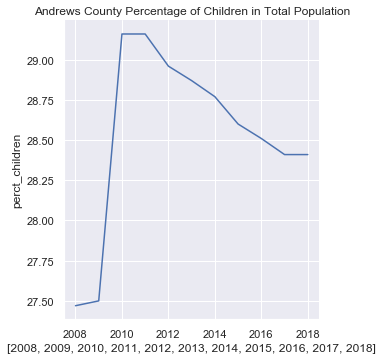

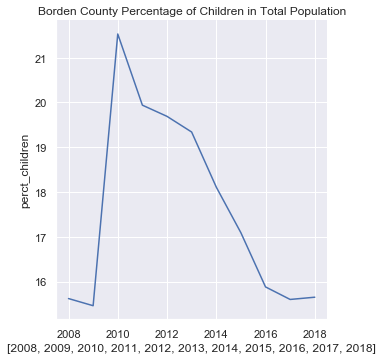

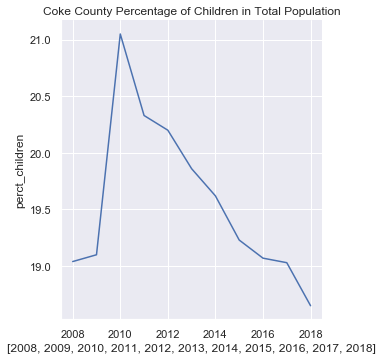

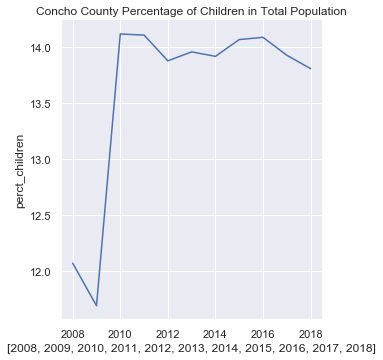

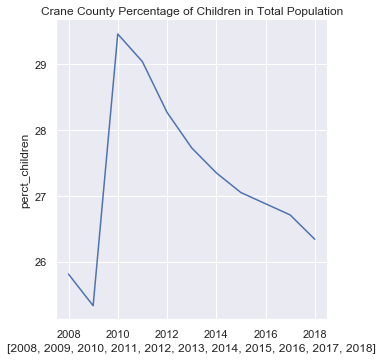

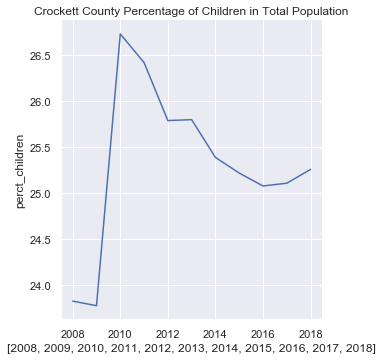

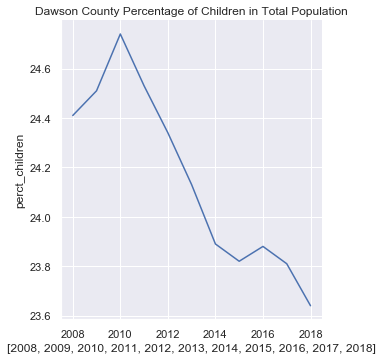

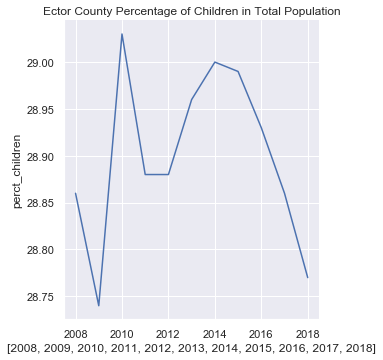

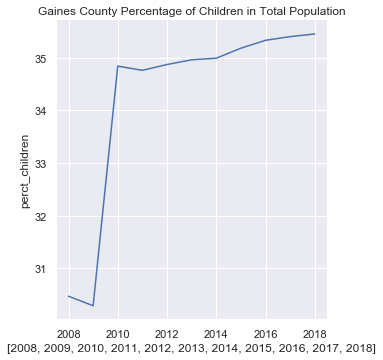

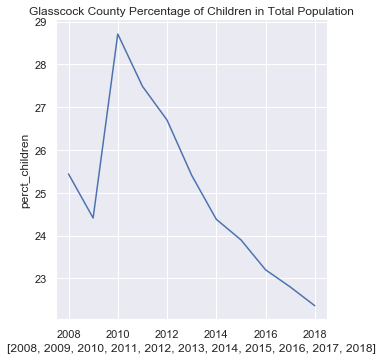

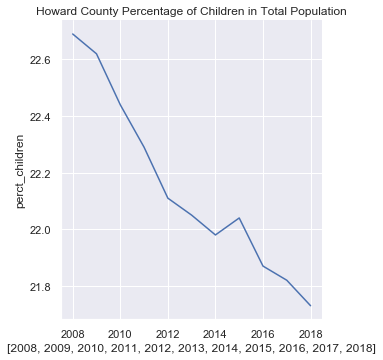

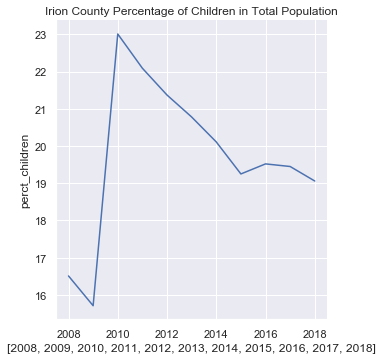

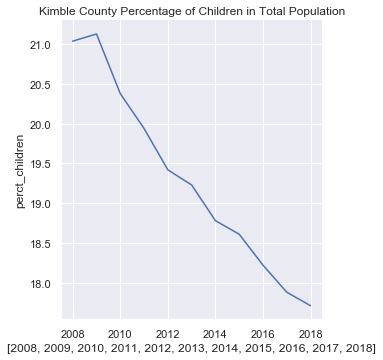

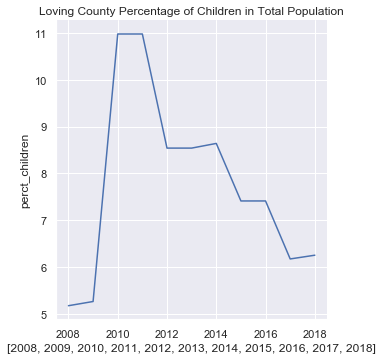

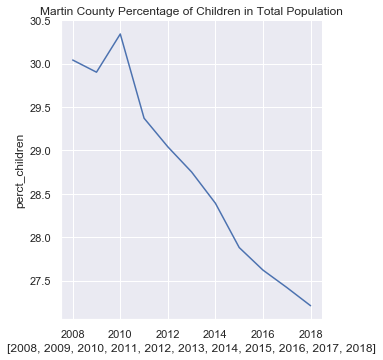

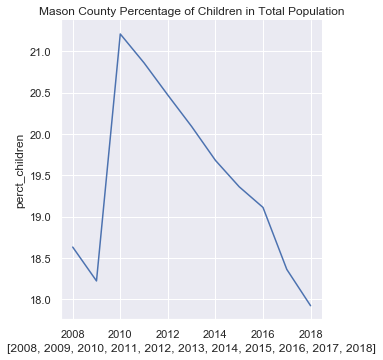

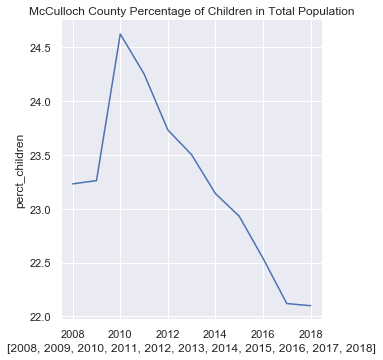

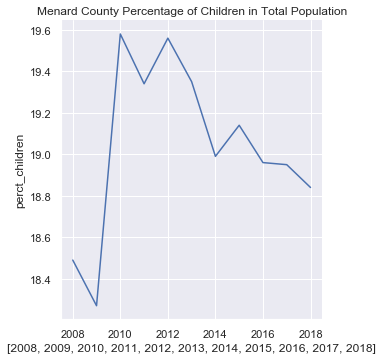

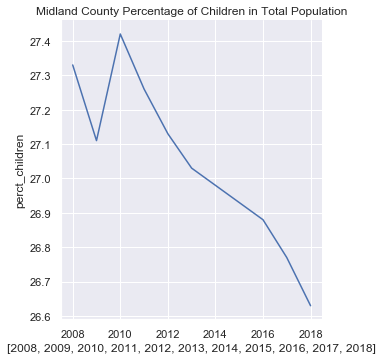

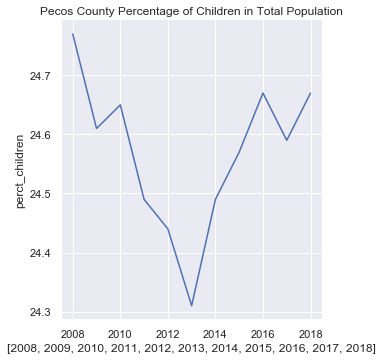

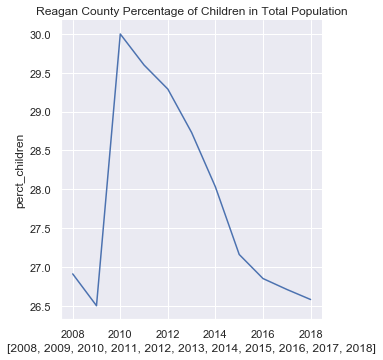

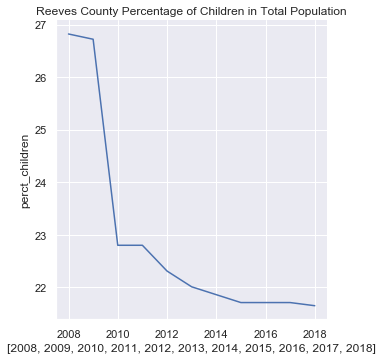

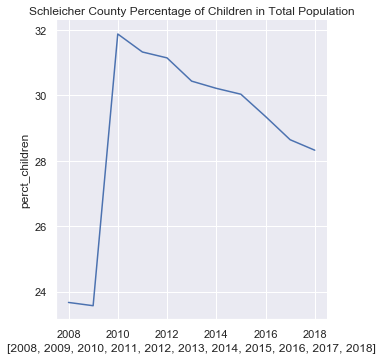

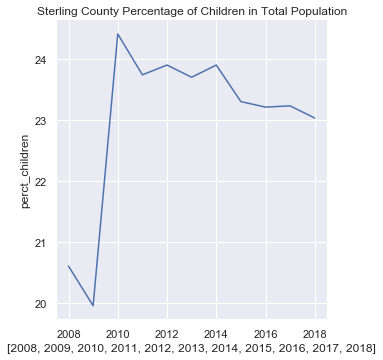

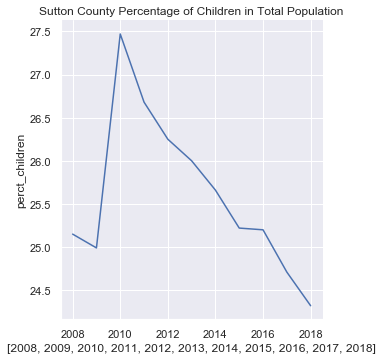

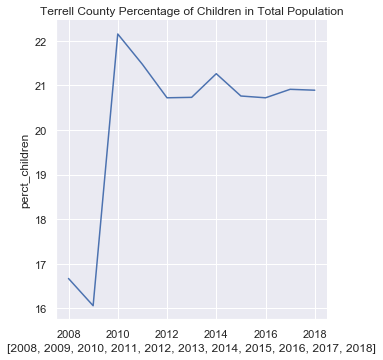

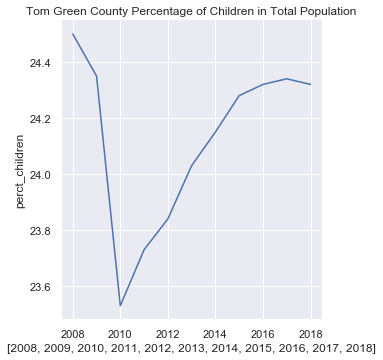

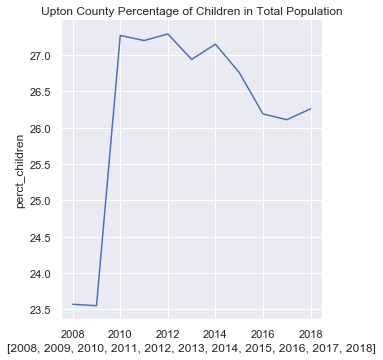

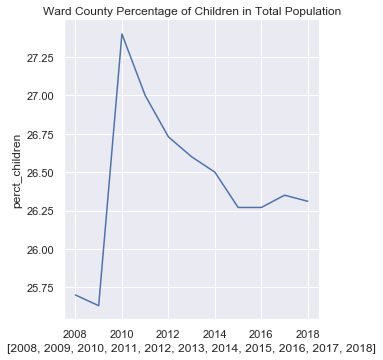

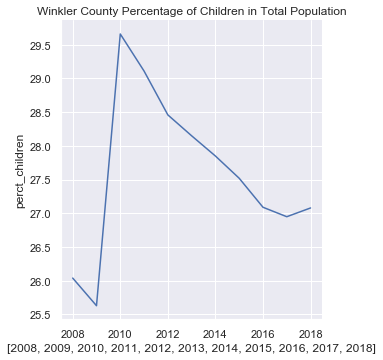

In [94]:
for element in midland_counties:
    sns.relplot(x=list(mid_by_county_by_yr.xs(element, level='county').index), y='perct_children', data=mid_by_county_by_yr.xs(element, level='county'), kind='line')
    plt.title(element+' County Percentage of Children in Total Population')
# plt.savefig()
plt.show()

### When analyzing the percentage of children in total population across all the different counties in Midland Region, there are some counties that do not follow the normal pattern of spiking in 2009 and then decreasing.

### These counties are: 

In [95]:
mid_by_county_by_yr.head()

child_pop  perct_children  tot_pop
county  year                                    
Andrews 2008     3821.0           27.47    13908
        2009     3893.0           27.50    14156
        2010     4312.0           29.16    14786
        2011     4396.0           29.16    15076
        2012     4443.0           28.96    15343

In [96]:
mid_by_county_by_yr.xs(2008, level='year')

,child_pop,perct_children,tot_pop
county,,,
Andrews,3821.0,27.47,13908
Borden,109.0,15.62,698
Coke,732.0,19.04,3844
Concho,450.0,12.07,3729
Crane,1039.0,25.81,4026
Crockett,1006.0,23.83,4221
Dawson,3400.0,24.41,13926
Ector,37761.0,28.86,130849
Gaines,4689.0,30.47,15389


In [97]:
sns.relplot(x=, y='perct_children', data=mid_by_county_by_yr, kind='line', hue=)
plt.title(element+' County Percentage of Children in Total Population')

SyntaxError: invalid syntax (<ipython-input-97-ba23722eac3f>, line 1)